In [1]:
!pip install --upgrade tqdm

# Importing Depdencencies

In [2]:
import pandas as pd
import numpy
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
import numpy as np
import torch
from tqdm import tqdm

In [3]:
import torch
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from torch import nn
import torchvision, torch
from torchsummary import summary
from torchvision import transforms as T
from torch import optim
import copy

In [5]:
import scipy.io as sio

# Loading Training and Testing Data

We will load the train and test dataset.

In [6]:
train_df = pd.read_csv('./dataset/Gungor_2018_VictorianAuthorAttribution_data-train.csv',encoding='latin-1')
test_df = pd.read_csv('./dataset/Gungor_2018_VictorianAuthorAttribution_data.csv',encoding='latin-1')

In [7]:
test_author = sio.loadmat('./dataset/test_author.mat')["test_author"]

In [8]:
test_df['author'] = test_author.reshape((test_df.shape[0]))
missing_authors = [5, 7, 31, 47, 49]
test_df = test_df.loc[~(test_df['author'].isin(missing_authors))]

In [9]:
test_df['author'] = test_df['author']-1

In [10]:
test_df.head()

,text,author
0,nt it seems te me how much money is he worth a...,0
1,to talk about why you heard of such a case as ...,0
2,my foot on the ground and said i believe you d...,0
3,hour or wait for miss oh wait for by all means...,0
4,will not listen to such words now go and remem...,0


#### Get Authors Names

In [11]:
author_list_path='./dataset/author_list.txt'

In [12]:
train_df['author'] = train_df['author']-1

In [13]:
train_df.head()

,text,author
0,ou have time to listen i will give you the ent...,0
1,wish for solitude he was twenty years of age a...,0
2,and the skirt blew in perfect freedom about th...,0
3,of san and the rows of shops opposite impresse...,0
4,an hour s walk was as tiresome as three in a s...,0


In [14]:
#Get author list
def load_author_names():
    f = open(author_list_path, 'r')
    author_list = f.read().split('\n')
    f.close()
    author_catalog = {}
    for i in range(len(author_list)):
        author_catalog[i] = author_list[i]
    return author_catalog

In [15]:
pprint.pprint(load_author_names())

{0: 'Arthur Conan Doyle',
 1: 'Charles Darwin',
 2: 'Charles Dickens',
 3: 'Edith Wharton',
 4: 'George Eliot',
 5: 'Horace Greeley',
 6: 'Jack London',
 7: 'James Baldwin',
 8: 'Jane Austen',
 9: 'John Muir',
 10: 'Joseph Conrad',
 11: 'Mark Twain',
 12: 'Nathaniel Hawthorne',
 13: 'Ralph Emerson',
 14: 'Robert Louis Stevenson',
 15: 'Rudyard Kipling',
 16: 'Sinclair Lewis',
 17: 'Theodore Dreiser',
 18: 'Thomas Hardy',
 19: 'Walt Whitman',
 20: 'Washington Irving',
 21: 'William Carleton',
 22: 'Albert Ross',
 23: 'Anne Manning',
 24: 'Arlo Bates',
 25: 'Bret Harte',
 26: 'Catharine Maria Sedgwick',
 27: 'Charles Reade',
 28: 'Edward Eggleston',
 29: 'Fergus Hume',
 30: 'Frances Hodgson Burnett',
 31: 'George Moore',
 32: 'George William Curtis',
 33: 'Helen Mathers',
 34: 'Henry Rider Haggard',
 35: 'Isabella Lucy Bird',
 36: 'Jacob Abbott',
 37: 'James Grant',
 38: 'James Payn',
 39: 'John Kendrick Bangs',
 40: 'John Pendleton Kennedy',
 41: 'John Strange Winter',
 42: 'Lucas Malet

#### Plot showing distribution of authors in the Train Dataset

array([[<AxesSubplot:title={'center':'author'}>]], dtype=object)

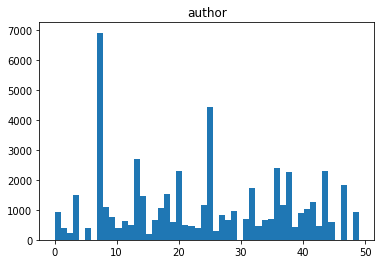

In [16]:
train_df.hist(column='author',grid=False,bins=50,rwidth=1)

In [1]:
#Get the Authors in dataframe
def get_author_content_distribution(train_df):
    author_catalog = load_author_names()
    lookup_table = {}
    for i in range(train_df['author'].count()):
        author_id = train_df['author'].iloc[i]
        try:
            if(author_catalog[author_id] in lookup_table.keys()):
                lookup_table[author_catalog[author_id]]+=1
            else:
                lookup_table[author_catalog[author_id]] = 1
        except:
            print("{} not present in Author list".format(author_id))
    return lookup_table

In [18]:
authors_dist = get_author_content_distribution(train_df)
len(authors_dist)

45

#### Split the training data

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
train_set, valid_set = train_test_split(train_df ,test_size=0.2,shuffle=True)

In [25]:
from nltk.tokenize import word_tokenize

In [26]:
test_df['text_length'] = test_df['text'].apply(lambda x: len(x.split(" ")))

In [27]:
test_df.head()

,text,author,text_length
0,nt it seems te me how much money is he worth a...,0,1001
1,to talk about why you heard of such a case as ...,0,1001
2,my foot on the ground and said i believe you d...,0,1001
3,hour or wait for miss oh wait for by all means...,0,1001
4,will not listen to such words now go and remem...,0,1001


In [ ]:
train_set['text'] = train_set['text'].apply(lambda x:" ".join(word_tokenize(x)))
train_set.head()

In [ ]:
train_set['text_length'] = train_set['text'].apply(lambda x: len(x.split(" ")))

In [ ]:
train_set.head()

In [ ]:
train_set['text_length'].hist(grid=False,rwidth=2)

In [ ]:
MAX_SENTENCE_LENGTH = train_set['text_length'].max()
EMBEDDING_DIM = 100

In [28]:
MAX_SENTENCE_LENGTH = test_df['text_length'].max()
EMBEDDING_DIM = 100

# Generate embeddings for each text entry in training dataframe and Save in a Pickle File

#### Generate Glove Embeddings

In [29]:
embedding_dictionary = {}
with open('./glove/glove.6B.100d.txt','r',encoding="utf8") as glove_file:
    for line in glove_file:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dictionary[word]=vectors
glove_file.close()

In [30]:
#Generate Embedding Matrix
def generate_word_embeddings(text):
    embedding_matrix = torch.zeros((MAX_SENTENCE_LENGTH, EMBEDDING_DIM))
    for idx, word in enumerate(text.split(" ")):
        if(idx>1007):
            break
        if(word in embedding_dictionary):
            embedding_vector = torch.from_numpy(embedding_dictionary.get(word))
            if(embedding_vector is not None):
                embedding_matrix[idx] = embedding_vector
    return embedding_matrix

In [31]:
test_df['embeddings'] = test_df['text'].apply(lambda x:generate_word_embeddings(x))

In [32]:
test_df.head()

,text,author,text_length,embeddings
0,nt it seems te me how much money is he worth a...,0,1001,"[[tensor(0.3181), tensor(1.0088), tensor(-0.26..."
1,to talk about why you heard of such a case as ...,0,1001,"[[tensor(-0.1897), tensor(0.0500), tensor(0.19..."
2,my foot on the ground and said i believe you d...,0,1001,"[[tensor(0.0803), tensor(-0.1086), tensor(0.72..."
3,hour or wait for miss oh wait for by all means...,0,1001,"[[tensor(-0.3571), tensor(-0.2348), tensor(0.0..."
4,will not listen to such words now go and remem...,0,1001,"[[tensor(-0.2670), tensor(0.4491), tensor(0.55..."


In [ ]:
train_set['embeddings'] = train_set['text'].apply(lambda x:generate_word_embeddings(x))

#### Save the embeddings in a pickle file

In [ ]:
train_set.to_pickle('auth_id_train_df.pkl')

In [ ]:
valid_set['embeddings'] = valid_set['text'].apply(lambda x:generate_word_embeddings(x))

In [ ]:
valid_set.to_pickle('auth_id_valid_df.pkl')

# Build LSTM Model

In [33]:
class LSTM(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,out_dim):
        super(LSTM,self).__init__()
        
        #Hidden Dimensions
        self.hidden_dim = hidden_dim
        
        #Number of Hidden Layers
        self.num_layers = num_layers
        
        #Building LSTM
        self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers, batch_first = True)
        self.sequential = nn.Sequential(nn.Linear(hidden_dim, 2*hidden_dim),nn.ReLU(),nn.Linear(2*hidden_dim, hidden_dim),nn.ReLU())

        self.fc = nn.Linear(hidden_dim, out_dim)
    
    def forward(self,x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Build Custom Dataset

In [34]:
class AuthorTextDataset(torch.utils.data.Dataset):
    def __init__(self,dataframe):
        embeddings = dataframe['embeddings'].values
        authors = dataframe['author'].values
        
        self.x = embeddings
        self.y = torch.tensor(authors)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

#### Load the Saved Embedding Space

In [35]:
%time train_set = pd.read_pickle("./auth_id_train_df.pkl")

CPU times: total: 14.7 s
Wall time: 1min 25s


In [36]:
%time valid_set = pd.read_pickle("./auth_id_valid_df.pkl")

CPU times: total: 8.88 s
Wall time: 15.4 s


In [37]:
valid_set.head()

,text,author,embeddings
3875,admired in others from having been long in a d...,7,"[[tensor(-0.2128), tensor(0.5968), tensor(-0.2..."
40589,observed was in the habit of leaving the house...,37,"[[tensor(-0.6898), tensor(0.0356), tensor(-0.5..."
11295,black thing but that is why i like you is dark...,8,"[[tensor(-0.0574), tensor(0.6859), tensor(0.16..."
35380,â he knew not why â except that he was always ...,32,"[[tensor(0.0079), tensor(0.8056), tensor(-0.22..."
36072,it expedient to set down benefit of the who ca...,32,"[[tensor(-0.3066), tensor(0.1682), tensor(0.98..."


# Generate Dataloaders

In [51]:
train_dataset = AuthorTextDataset(train_set)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=128,shuffle=False)

validation_dataset = AuthorTextDataset(valid_set)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset,batch_size=128,shuffle=False)

In [52]:
test_dataset = AuthorTextDataset(test_df)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=False)

In [53]:
examples = enumerate(train_dataloader)
batch_idx, (example_data,example_targets) = next(examples)
print(example_data.shape)

torch.Size([128, 1008, 100])


In [54]:
counter=0
for idx,(data,labels) in enumerate(train_dataloader):
    counter+=1
print("Total Number of batches: ",counter)

Total Number of batches:  336


In [55]:
def get_device():
#     return torch.device("cpu")
    if(torch.cuda.is_available()):
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [56]:
print(get_device())

cuda


# Training and Validation Pipeline

#### Train Method

The train method iterates through the dataloader to get the predicted values from the model, calculate loss and return average train loss for each epoch.

In [57]:
def train(model,data_loader, optimizer, criterion, device):
    model.to(device)
    model.train()
    correct = 0
    total = 0
    num_batches = 0
    train_loss = 0.0
    train_acc = 0.0
    for batch_idx, (feature_data,labels) in tqdm(enumerate(data_loader)):
        feature_data = feature_data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(feature_data)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == labels).sum()
        total += labels.size(0)        
        train_loss += loss.item()
        num_batches+=1
        
    train_acc = 100 * correct / total
    return train_loss/num_batches,train_acc

#### Validation Method

The test method iterates through the dataloader to get the compare predicted and ground truth values, it return average validation loss and accuracy of model.

In [58]:
def validate(model,data_loader, optimizer, criterion, device):
    model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
    num_batches = 0
    val_loss = 0.0
    val_acc = 0.0
    for batch_idx,(feature_data,labels) in tqdm(enumerate(data_loader)):
        feature_data = feature_data.to(device)
        labels = labels.to(device)
        output = model(feature_data)
        loss = criterion(output,labels)
        _,predicted = torch.max(output.data,1)
        correct += (predicted == labels).sum()
        total += labels.size(0)
        val_loss += loss.item()
        num_batches+=1
    val_acc = 100 * correct / total
    return val_loss/num_batches,val_acc

#### Training and Validation Pipeline

The training and validation pipeline collects train and validation loss along with accuracies and saves the model with maximum validation accuracy.

In [4]:
def fit_model(model,num_epochs,train_dl,validation_dl,best_model):
    test_losses=[]
    test_accuracies = []
    train_losses=[]
    train_accuracies=[]
    
    max_accuracy = -float('inf')
    best_model = model
    learn_rate = 0.01
    
    device = get_device()
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model,train_dl, optimizer, criterion, device)
        test_loss, test_acc = validate(model,validation_dl, optimizer, criterion, device)
        
        print("Epoch:{}, Train Loss: {:.4f}, Train Accuracy: {:.4f}, Valid Loss: {:.4f}, Valid Accuracy: {:.4f}"
                  .format(epoch,train_loss,train_acc,test_loss,test_acc))
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    
        if(test_acc>max_accuracy):
            torch.save(model,'ai_lstm_bs_model.pth')
            #best_model = copy.deepcopy(model)
            max_accuracy = test_acc
            print("Saving Best Model with Accuracy: ", max_accuracy)
    
    plot_loss(num_epochs,train_losses,test_losses)
    return best_model,max_accuracy

In [1]:
#Function to plot the Loss function values observed in both training and test
def plot_loss(num_epochs,train_losses,test_losses):
    
    # Using Numpy to create an array X
    X = range(num_epochs)
    
    # Assign variables to the y axis part of the curve
    y = train_losses
    z = test_losses
    
    plt.plot(X,y,color='blue')
    plt.plot(X,z,color='red')
    plt.legend(['Train Loss','Validation Loss'],loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Training and Validation Losses")

# Model Initialization: LSTM with 128 neurons and 2 hidden layer

In [62]:
input_dim = 100 #10 previous stock values
hidden_dim = 128
num_layers = 2
output_dim = 50

random_seed = 2
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim,out_dim=output_dim, num_layers=num_layers)
print(model)

LSTM(
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True)
  (sequential): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (fc): Linear(in_features=128, out_features=50, bias=True)
)


### Start of model training and validation process

336it [06:16,  1.12s/it]
84it [00:33,  2.48it/s]


Epoch:0, Train Loss: 3.3495, Train Accuracy: 16.7994, Valid Loss: 3.1485, Valid Accuracy: 20.8458
Saving Best Model with Accuracy:  tensor(20.8458, device='cuda:0')


336it [09:43,  1.74s/it]
84it [01:01,  1.37it/s]


Epoch:1, Train Loss: 2.7847, Train Accuracy: 26.8385, Valid Loss: 2.5374, Valid Accuracy: 30.2161
Saving Best Model with Accuracy:  tensor(30.2161, device='cuda:0')


336it [07:16,  1.30s/it]
84it [00:32,  2.61it/s]


Epoch:2, Train Loss: 2.2859, Train Accuracy: 36.3025, Valid Loss: 2.2454, Valid Accuracy: 37.5186
Saving Best Model with Accuracy:  tensor(37.5186, device='cuda:0')


336it [06:28,  1.16s/it]
84it [00:33,  2.51it/s]


Epoch:3, Train Loss: 1.9791, Train Accuracy: 43.9383, Valid Loss: 1.9150, Valid Accuracy: 46.5630
Saving Best Model with Accuracy:  tensor(46.5630, device='cuda:0')


336it [06:24,  1.15s/it]
84it [00:32,  2.58it/s]


Epoch:4, Train Loss: 1.6829, Train Accuracy: 52.2216, Valid Loss: 1.8508, Valid Accuracy: 48.1464
Saving Best Model with Accuracy:  tensor(48.1464, device='cuda:0')


336it [06:21,  1.13s/it]
84it [00:32,  2.61it/s]


Epoch:5, Train Loss: 1.4602, Train Accuracy: 58.2437, Valid Loss: 1.5821, Valid Accuracy: 55.9519
Saving Best Model with Accuracy:  tensor(55.9519, device='cuda:0')


336it [06:23,  1.14s/it]
84it [00:31,  2.63it/s]


Epoch:6, Train Loss: 1.2934, Train Accuracy: 62.8685, Valid Loss: 1.3868, Valid Accuracy: 60.4322
Saving Best Model with Accuracy:  tensor(60.4322, device='cuda:0')


336it [06:16,  1.12s/it]
84it [00:31,  2.64it/s]


Epoch:7, Train Loss: 1.1670, Train Accuracy: 66.1357, Valid Loss: 1.3757, Valid Accuracy: 61.7921
Saving Best Model with Accuracy:  tensor(61.7921, device='cuda:0')


336it [06:12,  1.11s/it]
84it [00:31,  2.64it/s]


Epoch:8, Train Loss: 1.0620, Train Accuracy: 68.7439, Valid Loss: 1.3178, Valid Accuracy: 63.1054
Saving Best Model with Accuracy:  tensor(63.1054, device='cuda:0')


336it [06:25,  1.15s/it]
84it [00:32,  2.57it/s]


Epoch:9, Train Loss: 0.9777, Train Accuracy: 71.3101, Valid Loss: 1.2951, Valid Accuracy: 64.4840
Saving Best Model with Accuracy:  tensor(64.4840, device='cuda:0')


336it [06:29,  1.16s/it]
84it [00:32,  2.60it/s]


Epoch:10, Train Loss: 0.9196, Train Accuracy: 72.7539, Valid Loss: 1.2125, Valid Accuracy: 66.7101
Saving Best Model with Accuracy:  tensor(66.7101, device='cuda:0')


336it [06:22,  1.14s/it]
84it [00:31,  2.64it/s]


Epoch:11, Train Loss: 0.8635, Train Accuracy: 74.2723, Valid Loss: 1.3483, Valid Accuracy: 63.8413


336it [06:25,  1.15s/it]
84it [00:31,  2.63it/s]


Epoch:12, Train Loss: 0.8086, Train Accuracy: 75.8302, Valid Loss: 1.1947, Valid Accuracy: 67.2690
Saving Best Model with Accuracy:  tensor(67.2690, device='cuda:0')


336it [06:30,  1.16s/it]
84it [00:32,  2.61it/s]


Epoch:13, Train Loss: 0.7412, Train Accuracy: 77.9167, Valid Loss: 1.2747, Valid Accuracy: 65.8998


336it [06:27,  1.15s/it]
84it [00:31,  2.64it/s]


Epoch:14, Train Loss: 0.7099, Train Accuracy: 78.4873, Valid Loss: 1.2927, Valid Accuracy: 65.7507


336it [06:26,  1.15s/it]
84it [00:31,  2.63it/s]


Epoch:15, Train Loss: 0.6969, Train Accuracy: 79.0648, Valid Loss: 1.2637, Valid Accuracy: 66.4680


336it [06:27,  1.15s/it]
84it [00:33,  2.54it/s]


Epoch:16, Train Loss: 0.6371, Train Accuracy: 80.7904, Valid Loss: 1.2197, Valid Accuracy: 68.7127
Saving Best Model with Accuracy:  tensor(68.7127, device='cuda:0')


336it [06:27,  1.15s/it]
84it [00:31,  2.65it/s]


Epoch:17, Train Loss: 0.6049, Train Accuracy: 81.8010, Valid Loss: 1.2302, Valid Accuracy: 68.6382


336it [06:31,  1.17s/it]
84it [00:32,  2.62it/s]


Epoch:18, Train Loss: 0.5948, Train Accuracy: 81.9035, Valid Loss: 1.2772, Valid Accuracy: 67.5671


336it [06:21,  1.14s/it]
84it [00:32,  2.58it/s]


Epoch:19, Train Loss: 0.5737, Train Accuracy: 82.4065, Valid Loss: 1.3565, Valid Accuracy: 66.5238


336it [06:24,  1.15s/it]
84it [00:49,  1.69it/s]


Epoch:20, Train Loss: 0.5611, Train Accuracy: 82.8373, Valid Loss: 1.3550, Valid Accuracy: 67.1107


336it [06:21,  1.14s/it]
84it [00:32,  2.56it/s]


Epoch:21, Train Loss: 0.5498, Train Accuracy: 83.1261, Valid Loss: 1.3347, Valid Accuracy: 67.3435


336it [06:25,  1.15s/it]
84it [00:32,  2.55it/s]


Epoch:22, Train Loss: 0.5085, Train Accuracy: 84.4092, Valid Loss: 1.3805, Valid Accuracy: 66.8964


336it [06:20,  1.13s/it]
84it [00:32,  2.59it/s]


Epoch:23, Train Loss: 0.4907, Train Accuracy: 84.9239, Valid Loss: 1.3090, Valid Accuracy: 69.0387
Saving Best Model with Accuracy:  tensor(69.0387, device='cuda:0')


336it [06:19,  1.13s/it]
84it [00:32,  2.59it/s]


Epoch:24, Train Loss: 0.4773, Train Accuracy: 85.0380, Valid Loss: 1.2767, Valid Accuracy: 69.6162
Saving Best Model with Accuracy:  tensor(69.6162, device='cuda:0')


336it [06:23,  1.14s/it]
84it [00:34,  2.44it/s]


Epoch:25, Train Loss: 0.4961, Train Accuracy: 84.6630, Valid Loss: 1.3234, Valid Accuracy: 68.8525


336it [06:20,  1.13s/it]
84it [00:34,  2.42it/s]


Epoch:26, Train Loss: 0.4687, Train Accuracy: 85.3547, Valid Loss: 1.3628, Valid Accuracy: 68.1446


336it [06:24,  1.14s/it]
84it [00:34,  2.47it/s]


Epoch:27, Train Loss: 0.4534, Train Accuracy: 85.9345, Valid Loss: 1.3341, Valid Accuracy: 68.0048


336it [06:28,  1.16s/it]
84it [00:33,  2.50it/s]


Epoch:28, Train Loss: 0.4239, Train Accuracy: 86.8148, Valid Loss: 1.3522, Valid Accuracy: 67.9676


336it [06:20,  1.13s/it]
84it [00:32,  2.60it/s]


Epoch:29, Train Loss: 0.4172, Train Accuracy: 86.9452, Valid Loss: 1.5183, Valid Accuracy: 65.5086


336it [06:12,  1.11s/it]
84it [00:32,  2.60it/s]


Epoch:30, Train Loss: 0.4101, Train Accuracy: 87.1548, Valid Loss: 1.3767, Valid Accuracy: 67.2504


336it [06:22,  1.14s/it]
84it [00:31,  2.63it/s]


Epoch:31, Train Loss: 0.3860, Train Accuracy: 87.9023, Valid Loss: 1.3033, Valid Accuracy: 69.4765


336it [06:23,  1.14s/it]
84it [00:32,  2.59it/s]


Epoch:32, Train Loss: 0.3801, Train Accuracy: 87.9861, Valid Loss: 1.2808, Valid Accuracy: 71.0693
Saving Best Model with Accuracy:  tensor(71.0693, device='cuda:0')


336it [06:19,  1.13s/it]
84it [00:32,  2.59it/s]


Epoch:33, Train Loss: 0.3813, Train Accuracy: 87.9395, Valid Loss: 1.3665, Valid Accuracy: 69.2716


336it [05:22,  1.04it/s]
84it [00:31,  2.66it/s]


Epoch:34, Train Loss: 0.3560, Train Accuracy: 88.7965, Valid Loss: 1.3732, Valid Accuracy: 69.1040


336it [05:26,  1.03it/s]
84it [00:31,  2.65it/s]


Epoch:35, Train Loss: 0.3523, Train Accuracy: 88.7988, Valid Loss: 1.3985, Valid Accuracy: 68.6848


336it [05:23,  1.04it/s]
84it [00:32,  2.60it/s]


Epoch:36, Train Loss: 0.3476, Train Accuracy: 89.0643, Valid Loss: 1.4231, Valid Accuracy: 69.1598


336it [06:18,  1.13s/it]
84it [00:33,  2.51it/s]


Epoch:37, Train Loss: 0.4006, Train Accuracy: 87.4715, Valid Loss: 1.3388, Valid Accuracy: 70.4825


336it [06:18,  1.13s/it]
84it [00:32,  2.58it/s]


Epoch:38, Train Loss: 0.3738, Train Accuracy: 88.1980, Valid Loss: 1.3699, Valid Accuracy: 69.0108


336it [06:20,  1.13s/it]
84it [00:32,  2.58it/s]


Epoch:39, Train Loss: 0.3527, Train Accuracy: 88.9129, Valid Loss: 1.4310, Valid Accuracy: 69.0108


336it [06:29,  1.16s/it]
84it [00:32,  2.57it/s]


Epoch:40, Train Loss: 0.3184, Train Accuracy: 89.6931, Valid Loss: 1.3357, Valid Accuracy: 70.9016


336it [06:18,  1.13s/it]
84it [00:32,  2.55it/s]


Epoch:41, Train Loss: 0.3148, Train Accuracy: 90.0307, Valid Loss: 1.3373, Valid Accuracy: 70.4639


336it [06:26,  1.15s/it]
84it [00:33,  2.52it/s]


Epoch:42, Train Loss: 0.3061, Train Accuracy: 90.2194, Valid Loss: 1.3781, Valid Accuracy: 70.2589


336it [06:23,  1.14s/it]
84it [00:31,  2.64it/s]


Epoch:43, Train Loss: 0.3105, Train Accuracy: 90.0354, Valid Loss: 1.3704, Valid Accuracy: 71.0972
Saving Best Model with Accuracy:  tensor(71.0972, device='cuda:0')


336it [06:09,  1.10s/it]
84it [00:33,  2.54it/s]


Epoch:44, Train Loss: 0.3133, Train Accuracy: 89.9399, Valid Loss: 1.3402, Valid Accuracy: 71.3394
Saving Best Model with Accuracy:  tensor(71.3394, device='cuda:0')


336it [06:18,  1.13s/it]
84it [00:33,  2.54it/s]


Epoch:45, Train Loss: 0.3210, Train Accuracy: 89.7047, Valid Loss: 1.4237, Valid Accuracy: 68.5823


336it [06:16,  1.12s/it]
84it [00:32,  2.60it/s]


Epoch:46, Train Loss: 0.2998, Train Accuracy: 90.3288, Valid Loss: 1.4519, Valid Accuracy: 69.2530


336it [06:10,  1.10s/it]
84it [00:32,  2.60it/s]


Epoch:47, Train Loss: 0.3026, Train Accuracy: 90.1937, Valid Loss: 1.4867, Valid Accuracy: 68.8245


336it [06:13,  1.11s/it]
84it [00:32,  2.57it/s]


Epoch:48, Train Loss: 0.3109, Train Accuracy: 90.0657, Valid Loss: 1.4653, Valid Accuracy: 69.3741


336it [06:14,  1.11s/it]
84it [00:31,  2.64it/s]


Epoch:49, Train Loss: 0.3072, Train Accuracy: 89.9981, Valid Loss: 1.5100, Valid Accuracy: 68.8618


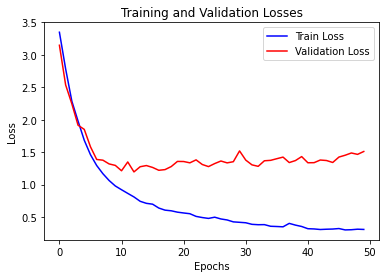

In [63]:
num_epochs = 50
best_model = model
best_model,max_acc = fit_model(model,num_epochs,train_dataloader,validation_dataloader,best_model)

We performed multiple experiments on the training and validation dataset. The model mentioned in the previous cell, is the last experiment we performed on LSTM.

Other experiments performed on LSTM are:

In [ ]:
input_dim = 100 
hidden_dim = 128
num_layers = 2
output_dim = 50
random_seed = 2
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
model_exp1 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim,out_dim=output_dim, num_layers=num_layers)

# Testing the Trained Model

In [64]:
best_model = torch.load('ai_lstm_bs_model.pth')

In [65]:
print(best_model)

LSTM(
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True)
  (sequential): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (fc): Linear(in_features=128, out_features=50, bias=True)
)


In [66]:
from sklearn.metrics import classification_report

### Generate Predicted Values for Test Dataset

In [72]:
device = get_device()
best_model.to(device)
predicted_results = []
for batch_idx,(feature_data,labels) in enumerate(validation_dataloader):
    feature_data = feature_data.to(device)
    labels = labels.to(device)
    output = best_model(feature_data)
    _,predicted = torch.max(output.data,1)
    predicted_results = predicted_results+list(predicted.cpu().detach().numpy())
    
print(len(predicted_results))

10736


In [75]:
y_true = valid_set['author'].to_list()

# Generate Classification Report

In [76]:
print(classification_report(y_true, predicted_results))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       203
           1       0.32      0.26      0.29        94
           2       0.48      0.22      0.31        49
           3       0.48      0.52      0.50       279
           5       0.43      0.38      0.40        76
           7       0.82      0.84      0.83      1364
           8       0.58      0.59      0.58       225
           9       0.66      0.71      0.69       162
          10       0.58      0.57      0.57        69
          11       0.63      0.61      0.62       109
          12       0.77      0.64      0.70       119
          13       0.76      0.75      0.76       561
          14       0.81      0.64      0.72       289
          15       0.09      0.10      0.10        40
          16       0.41      0.39      0.39       122
          17       0.73      0.58      0.65       203
          18       0.69      0.78      0.73       323
          19       0.66    